In [ ]:
from bs4 import BeautifulSoup
import requests
import time
import csv
from tqdm import tqdm
from transformers import pipeline
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [2]:
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36",
    "Accept": "text/html,application/xhtml+xml,application/xml;q=0.9,*/*;q=0.8",
    "Accept-Language": "en-US,en;q=0.5",
    "Accept-Encoding": "gzip, deflate, br",  # Supporte la compression
    "Connection": "keep-alive",
    "Upgrade-Insecure-Requests": "1",  # Pour indiquer le support de HTTPS et les mises à jour
    "Cache-Control": "max-age=0",  # Pour forcer le rechargement des ressources
    "TE": "Trailers"  # Support de la transmission avec les trailers HTTP/2
}


In [3]:
def scrape_all_page(url):
    all_articles = []  # Liste des articles collectés
    seen_articles = set()  # Ensemble pour éviter les doublons d'URL

    try:
        # Envoyer une requête HTTP pour récupérer la page
        response = requests.get(url, headers=headers, timeout=10)
        if response.status_code == 200:
            soup = BeautifulSoup(response.text, 'html.parser')
            
            # Trouver tous les articles via la classe "articlePreview-content"
            articles = soup.find_all("div", class_="articlePreview-content")
            
            for article in articles:
                # Extraire le lien de l'article
                link_element = article.find("a", href=True)
                article_url = f"https://www.huffingtonpost.fr{link_element['href']}" if link_element else ""

                # Extraire le titre
                title_element = article.find("div", class_="title")
                title_text = title_element.find("h2").get_text(strip=True) if title_element else ""

                # Extraire la description
                description_element = article.find("div", class_="articlePreview-chapo")
                description_text = description_element.get_text(strip=True) if description_element else ""

                # Vérifier si l'article est déjà collecté
                if article_url and article_url not in seen_articles:
                    all_articles.append([title_text, description_text, article_url])
                    seen_articles.add(article_url)

            return all_articles

        else:
            print(f"Erreur HTTP {response.status_code} lors de l'accès à {url}")
            return []

    except requests.RequestException as e:
        print(f"Erreur de requête pour {url}: {e}")
        return []


In [4]:
def scrape_all_pages(base_url, total_pages):
    all_articles = []  # Liste pour collecter tous les articles

    for page_num in range(1, total_pages + 1):
        # Construire l'URL pour chaque page
        if page_num == 1:
            url = base_url  # La première page n'a pas de suffixe "?page="
        else:
            url = f"{base_url}?page={page_num}"
        
        print(f"Scraping de la page : {url}")
        articles = scrape_all_page(url)  # Appeler la fonction pour une page
        all_articles.extend(articles)  # Ajouter les articles collectés

        print(f"Page {page_num} : {len(articles)} articles collectés.")

    print(f"Scraping terminé : {len(all_articles)} articles collectés au total.")
    return all_articles


In [5]:
# Fonction pour exporter les résultats en CSV
def export_to_csv_2(dataset, filename="filtered_articles.csv"):
    with open(filename, mode='w', encoding='utf-8', newline='') as file:
        fieldnames = ["Title", "Summary", "Date", "Paragraphs"]
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()

        for data in dataset:
            # Convertir la liste de paragraphes en une seule chaîne avec des doubles sauts de ligne
            data["Paragraphs"] = "\n\n".join(data["Paragraphs"])
            writer.writerow(data)

    print(f"Les résultats ont été sauvegardés dans '{filename}'.")

def export_to_csv(dataset, filename="articles_dataset.csv"):
    # Ouvrir le fichier CSV en mode écriture
    with open(filename, mode='w', encoding='utf-8', newline='') as file:
        # Définir les noms des colonnes (en-têtes)
        fieldnames = ["Title", "Summary", "URL"]
        
        # Créer un objet DictWriter pour écrire dans le fichier
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        
        # Écrire les en-têtes dans le fichier
        writer.writeheader()
        
        # Écrire chaque ligne de données dans le fichier
        for data in dataset:
            writer.writerow(data)

    print(f"Les résultats ont été sauvegardés dans '{filename}'.")


In [6]:
base_url = "https://www.huffingtonpost.fr/agriculture/"
total_pages = 37

# Scraper tous les articles des 37 pages
all_articles = scrape_all_pages(base_url, total_pages)

# Sauvegarder les résultats dans un fichier CSV
export_to_csv([{"Title": title, "Summary": desc, "URL": url} for title, desc, url in all_articles], "agriculture_huffpost.csv")


Scraping de la page : https://www.huffingtonpost.fr/agriculture/
Page 1 : 30 articles collectés.
Scraping de la page : https://www.huffingtonpost.fr/agriculture/?page=2
Page 2 : 30 articles collectés.
Scraping de la page : https://www.huffingtonpost.fr/agriculture/?page=3
Page 3 : 30 articles collectés.
Scraping de la page : https://www.huffingtonpost.fr/agriculture/?page=4
Page 4 : 30 articles collectés.
Scraping de la page : https://www.huffingtonpost.fr/agriculture/?page=5
Page 5 : 30 articles collectés.
Scraping de la page : https://www.huffingtonpost.fr/agriculture/?page=6
Page 6 : 30 articles collectés.
Scraping de la page : https://www.huffingtonpost.fr/agriculture/?page=7
Page 7 : 30 articles collectés.
Scraping de la page : https://www.huffingtonpost.fr/agriculture/?page=8
Page 8 : 30 articles collectés.
Scraping de la page : https://www.huffingtonpost.fr/agriculture/?page=9
Page 9 : 30 articles collectés.
Scraping de la page : https://www.huffingtonpost.fr/agriculture/?page=1

In [ ]:
all_articles[:1]

[['C’est quoi cet oiseau qui a mis un coup d’arrêt au projet de bassine à Sainte-Soline',
  'Ce mercredi, la cour administrative d’appel de Bordeaux a jugé les autorisations délivrées à quatre réserves d’irrigation du Poitou, dont celle de Sainte-Soline, illégales.',
  'https://www.huffingtonpost.fr/environnement/article/sainte-soline-l-outarde-canepetiere-l-oiseau-qui-a-mis-un-coup-d-arret-au-projet-de-bassine_243753.html'],
 ['La justice déclare illégale la bassine controversée de Sainte-Soline, mais...',
  'En plus de Sainte-Soline, la justice a également jugé illégales les autorisations délivrées à trois autres mégabassines du Poitou ce mercredi.',
  'https://www.huffingtonpost.fr/justice/article/sainte-soline-la-justice-juge-cette-bassine-controversee-des-deux-sevres-illegale_243746.html'],
 ['Ces agriculteurs ne décolèrent pas après la censure et les «\xa0chamailleries\xa0» de politiques',
  'La chute de Michel Barnier est un coup de massue pour de nombreux agriculteurs, qui croy

In [21]:
def fetch_article_detail(articles):
    """
    Enrichit une liste d'articles avec les paragraphes et la date de publication.
    
    :param articles: Liste de listes contenant titre, résumé et URL pour chaque article.
    :return: Liste enrichie avec paragraphes et date de publication.
    """
    articles_enrichis = []
    
    for article in articles:
        titre, resume, url = article
        try:
            # Récupération de la page HTML
            response = requests.get(url)
            response.raise_for_status()  # Vérifie que la requête est réussie
            soup = BeautifulSoup(response.content, 'html.parser')
            
            # Extraction des paragraphes
            paragraphes = [
                p.get_text(strip=True) for p in soup.find_all('p', class_='asset asset-text')
            ]
            
            # Extraction de la date de publication
            date_element = soup.find('time', class_='article-metas')
            if date_element:
                date_publication = date_element.find('span', class_='article-metas__date')
                date_publication = date_publication.get_text(strip=True) if date_publication else "Date inconnue"
            else:
                date_publication = "Date inconnue"
            
            # Ajouter les données enrichies à l'article
            articles_enrichis.append([titre, resume, url, paragraphes, date_publication])
        
        except Exception as e:
            # En cas d'erreur, log et continuer
            print(f"Erreur pour l'article : {titre} ({url}) - {e}")
            articles_enrichis.append([titre, resume, url, [], "Erreur lors de l'extraction"])
    
    return articles_enrichis


In [30]:
# Fonction pour vérifier si "bio" est dans le texte et retourner les phrases contenant "bio"
def find_sentences_with_bio(text):
    text = text.lower()
    sentences = text.split('.')  # Diviser le texte en phrases
    bio_sentences = [sentence.strip() for sentence in sentences if 'bio ' in sentence or 'biologique' in sentence]
    return bio_sentences

# Fonction pour filtrer les articles contenant le mot "bio" et ajouter les phrases correspondantes
def filter_articles_with_bio(dataset):
    filtered_articles = []
    total_articles = len(dataset)

    # Initialiser tqdm pour la boucle avec un calcul du temps estimé
    start_time = time.time()  # Démarrer le chronomètre

    for i, article in tqdm(enumerate(dataset), total=total_articles, desc="Filtrage des articles", unit="article"):
        bio_sentences = []

        # Vérifier si "bio" est dans le titre (élément 0 de la liste)
        bio_sentences += find_sentences_with_bio(article[0])

        # Vérifier si "bio" est dans le résumé (élément 1 de la liste)
        bio_sentences += find_sentences_with_bio(article[1])

        # Vérifier chaque paragraphe (élément 3 de la liste)
        for paragraph in article[3]:
            bio_sentences += find_sentences_with_bio(paragraph)

        if bio_sentences:  # Ajouter seulement si des phrases contenant "bio" ont été trouvées
            article_with_bio = article.copy()
            article_with_bio.append(bio_sentences)  # Ajouter uniquement la liste des phrases contenant "bio"
            filtered_articles.append(article_with_bio)

        # Calculer et afficher le temps estimé restant
        elapsed_time = time.time() - start_time  # Temps écoulé
        progress = (i + 1) / total_articles  # Progression
        estimated_time_left = elapsed_time / progress - elapsed_time  # Temps estimé restant
        print(f"\rProgression : {progress * 100:.2f}% - Temps restant estimé : {estimated_time_left / 60:.2f} minutes", end="")

    print()  # Pour un retour à la ligne après l'affichage du progrès
    return filtered_articles


In [23]:
# Scraper les détails de chaque article dans `all_articles`
detailed_articles = fetch_article_detail(all_articles)



In [25]:
detailed_articles[:2]

[['C’est quoi cet oiseau qui a mis un coup d’arrêt au projet de bassine à Sainte-Soline',
  'Ce mercredi, la cour administrative d’appel de Bordeaux a jugé les autorisations délivrées à quatre réserves d’irrigation du Poitou, dont celle de Sainte-Soline, illégales.',
  'https://www.huffingtonpost.fr/environnement/article/sainte-soline-l-outarde-canepetiere-l-oiseau-qui-a-mis-un-coup-d-arret-au-projet-de-bassine_243753.html',
  ['ENVIRONNEMENT - C’est un oiseau qui contrarie les plans des agriculteurs du Poitou favorables auxmégabassines. Ce mercredi 18\xa0décembre, quatre d’entre elles –notamment celle de Sainte-Soline– ont vu leurautorisation suspenduepar la justice. Pour cause, ces réserves d’irrigation sont «de nature à détruire tout ou une partie de l’habitat\xa0»de l’outarde canepetière, d’après la cour administrative d’appel de Bordeaux.\xa0Dans cette région, la population de cesoiseauxn’est estimée qu’à quelques centaines, menacés parl’agriculture intensive.',
   'Selon les info

In [31]:
# Filtrer les articles contenant le mot "bio"
filtered_articles = filter_articles_with_bio(detailed_articles)



Filtrage des articles: 100%|██████████| 1102/1102 [00:00<00:00, 13018.34article/s]

Progression : 100.00% - Temps restant estimé : 0.00 minutes


In [36]:

# Charger explicitement le modèle de sentiment d'Hugging Face
sentiment_analyzer = pipeline("sentiment-analysis", model="distilbert/distilbert-base-uncased-finetuned-sst-2-english")

def analyze_sentiment_bio_with_model(text):
    """
    Utilise un modèle open-source pour analyser le sentiment d'un texte concernant le bio.
    Le score sera entre 0 (négatif) et 1 (positif).
    """
    # Utiliser le modèle de sentiment pour prédire le sentiment
    result = sentiment_analyzer(text)

    # Le modèle retourne une liste avec un dictionnaire contenant les labels et scores
    sentiment = result[0]
    
    # Convertir le label en score : 'LABEL_1' est positif, 'LABEL_0' est négatif
    if sentiment['label'] == 'POSITIVE':
        return sentiment['score']
    else:
        return 1 - sentiment['score']  # Retourner un score entre 0 et 1 pour un sentiment négatif


Device set to use cpu


In [37]:
# Fonction pour appliquer l'analyse de sentiment à chaque article dans la liste
def add_sentiment_score_to_articles(articles):
    """
    Applique l'analyse de sentiment sur chaque phrase ajoutée à l'article
    et ajoute la moyenne des scores de sentiment à chaque article.
    """
    for article in articles:
        # Extraire les phrases ajoutées (dernier élément de l'article)
        sentences = article[-1]

        # Appliquer l'analyse de sentiment à chaque phrase
        sentiment_scores = [analyze_sentiment_bio_with_model(sentence) for sentence in sentences]

        # Calculer la moyenne des scores
        average_score = sum(sentiment_scores) / len(sentiment_scores) if sentiment_scores else 0

        # Ajouter la moyenne au dictionnaire
        article.append(average_score)  # Ajouter directement le score moyen comme dernier élément

    return articles

In [38]:
final_data = add_sentiment_score_to_articles(filtered_articles)

In [49]:
final_data[0]

['Pourquoi les agriculteurs menacent de ressortir les tracteurs',
 'Les aides européennes pour les agriculteurs en bio ou engagés pour la transition écologique accusent plusieurs mois de retard.',
 'https://www.huffingtonpost.fr/france/article/agriculteurs-en-colere-pourquoi-les-syndicats-menacent-de-ressortir-les-tracteurs-sans-blocage-pour-l-instant-clx1_235430.html',
 ['AGRICULTURE - L’art de semer des promesses. Au début de l’année, alors que lacolère des agriculteursse faisait entendre à travers le pays,Gabriel Attals’engageait solennellement à apaiser les tensions en garantissant que«\xa0d’ici le 15\xa0mars, toutes les aides PAC seraient versées sur les comptes bancaires des exploitants\xa0». Quelques semaines plus tard, n’ayant pas tenu ce délai, le ministère de l’Agriculture annonçait que les aides arriveraient finalement au plus tard le 15\xa0juin.',
  'Or ce jour est passé et des milliers de fermes attendent toujours leurs paiements, en particulier lesexploitants bioou en MAE

In [51]:
# Fonction pour enregistrer les données au format CSV
def save_to_csv_final(data, filename):
    """
    Enregistre la liste de données au format CSV.
    
    :param data: Liste de listes contenant les données des articles.
    :param filename: Nom du fichier CSV de sortie.
    """
    # Définir les en-têtes en fonction de la structure des données
    headers = [
        "Title", 
        "Summary", 
        "URL", 
        "Paragraphs", 
        "Date", 
        "Found_in", 
        "Average_Sentiment_Score"
    ]
    
    # Écriture dans le fichier CSV
    with open(filename, mode='w', encoding='utf-8', newline='') as file:
        writer = csv.writer(file)
        
        # Écrire les en-têtes
        writer.writerow(headers)
        
        # Écrire les données
        for row in data:
            writer.writerow(row)

# Exemple d'utilisation
save_to_csv_final(final_data, "data_huffpost.csv")

In [ ]:
# Fonction pour afficher les mois avec couleurs basées sur le score moyen
def plot_months_with_color_based_on_score(data):
    """
    Génère un graphique montrant le nombre d'articles par mois, avec une couleur différente pour chaque mois
    en fonction du score moyen des articles de ce mois. Le score est extrait de la dernière colonne des données.

    :param data: Liste d'articles où la date de publication se trouve au 5ème élément et le score dans la dernière colonne.
    """
    # Initialisation de dictionnaires pour compter les articles et calculer la somme des scores par mois
    articles_per_month = {}
    scores_per_month = {}

    for entry in data:
        date_str = entry[4]  # La date est au 5ème élément
        score = entry[-1]  # Le score est dans la dernière colonne

        try:
            # Conversion de la date au format 'DD/MM/YYYY HH:MM'
            date_obj = datetime.strptime(date_str, '%d/%m/%Y %H:%M')
            
            # Formater la date pour obtenir le mois et l'année (format 'YYYY-MM')
            month_year = date_obj.strftime('%Y-%m')
            
            # Incrémenter le compteur pour le mois et ajouter le score pour le calcul du score moyen
            if month_year not in articles_per_month:
                articles_per_month[month_year] = 0
                scores_per_month[month_year] = 0.0
            articles_per_month[month_year] += 1
            scores_per_month[month_year] += score
        except ValueError as e:
            print(f"Erreur de format de date pour '{entry[0]}': {e}")
            continue

    # Calculer le score moyen par mois
    average_scores = {month: scores_per_month[month] / articles_per_month[month] for month in articles_per_month}

    # Créer une liste de tous les mois de l'année (en format YYYY-MM)
    all_months = pd.date_range(start=min(pd.to_datetime(list(articles_per_month.keys()))), 
                               end=max(pd.to_datetime(list(articles_per_month.keys()))), 
                               freq='MS').strftime('%Y-%m').tolist()

    # Liste des mois avec ou sans articles
    month_labels = []
    month_counts = []
    month_scores = []
    
    # Ajouter des mois manquants (ceux sans articles)
    for month in all_months:
        month_labels.append(month)
        month_counts.append(articles_per_month.get(month, 0))
        month_scores.append(average_scores.get(month, 0))

    # Créer un DataFrame avec les mois, le nombre d'articles et le score moyen
    df = pd.DataFrame({
        'Month': month_labels,
        'Article_Count': month_counts,
        'Average_Score': month_scores
    })

    # Créer une échelle de couleurs pour les scores (de rouge à vert)
    norm = mcolors.Normalize(vmin=0, vmax=1)
    cmap = plt.colormaps['RdYlGn']  # Palette de couleurs allant de rouge (0) à vert (1)
    
    # Tracer les données
    fig, ax = plt.subplots(figsize=(12, 7))
    bar_colors = [cmap(norm(score)) for score in df['Average_Score']]  # Couleur des barres en fonction du score moyen
    bars = ax.bar(df['Month'], df['Article_Count'], color=bar_colors)

    # Ajouter des labels et un titre
    ax.set_xlabel('Année', fontsize=12)
    ax.set_ylabel('Nombre d\'Articles', fontsize=12)
    ax.set_title('Nombre d\'Articles par Mois avec Scores Moyens', fontsize=14)

    # Rotation des labels de l'axe X pour une meilleure lisibilité
    plt.xticks(rotation=45, fontsize=10)

    # Définir les ticks de l'axe X (positionner les mois)
    tick_positions = range(len(df['Month']))
    ax.set_xticks(tick_positions)

    # Ne mettre l'année qu'une seule fois par année
    ax.set_xticklabels([label if i == 0 or label[:4] != df['Month'][i-1][:4] else '' for i, label in enumerate(df['Month'])])

    # Ajouter une grille
    ax.grid(axis='y', linestyle='--', alpha=0.7)

    # Ajouter une légende de couleur (colorbar)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])  # Nécessaire pour afficher la légende
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.01)
    cbar.set_label('Score Moyen')

    # Ajustement des marges
    plt.tight_layout()

    # Afficher le graphique
    plt.show()


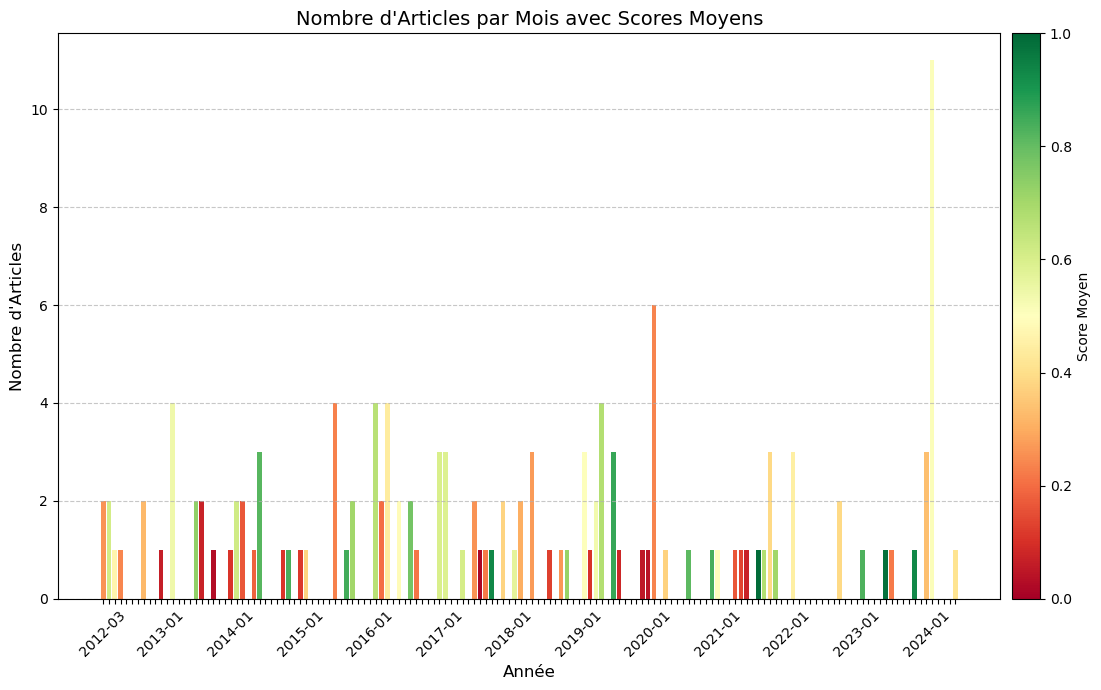

In [80]:
plot_months_with_color_based_on_score(final_data)